In [2]:
import nltk
import joblib
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from nltk.corpus import stopwords
from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve


In [3]:
dataset=pd.read_csv("C:\\Users\\ajlad\Downloads\\bbc_data.csv")

In [4]:
dataset

,data,labels
0,Musicians to tackle US red tape Musicians gro...,entertainment
1,"U2s desire to be number one U2, who have won ...",entertainment
2,Rocker Doherty in on-stage fight Rock singer ...,entertainment
3,Snicket tops US box office chart The film ada...,entertainment
4,"Oceans Twelve raids box office Oceans Twelve,...",entertainment
...,...,...
2220,Warning over Windows Word files Writing a Mic...,tech
2221,Fast lifts rise into record books Two high-sp...,tech
2222,Nintendo adds media playing to DS Nintendo is...,tech
2223,Fast moving phone viruses appear Security fir...,tech


In [5]:
dataset.isnull().sum()

data      0
labels    0
dtype: int64

In [6]:
dataset.describe()

,data,labels
count,2225,2225
unique,2127,5
top,Spain coach faces racism inquiry Spains Footb...,sport
freq,2,511


In [8]:
def preprocess(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

In [10]:
x=dataset["data"].apply(preprocess)
y=dataset["labels"]

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer=TfidfVectorizer()
x=vectorizer.fit_transform(x)

In [12]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=2)

In [14]:
# Apply PCA
pca = PCA(n_components=100, svd_solver='arpack')  # Retain 95% of variance
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

# Train and evaluate the SVM model with PCA
param_grid = {'C': [0.1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(LinearSVC(), param_grid, cv=5)
grid_search.fit(x_train_pca, y_train)
best_C = grid_search.best_params_['C']

sv_model = LinearSVC()
sv_model.fit(x_train_pca, y_train)
train_accuracy = accuracy_score(y_train, sv_model.predict(x_train_pca))
val_accuracy = accuracy_score(y_test, sv_model.predict(x_test_pca))
cross_val_scores = cross_val_score(sv_model, pca.transform(x), y, cv=5)
mean_cv_accuracy = cross_val_scores.mean()

print(f'SVM Training Accuracy: {train_accuracy}')
print(f'SVM Validation Accuracy: {val_accuracy}')
print(f'SVM Mean CV Accuracy: {mean_cv_accuracy}')

# Train and evaluate the Random Forest model with PCA
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(x_train_pca, y_train)
y_pred_rf = rf_model.predict(x_test_pca)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Test Accuracy: {rf_accuracy}')
rf_cross_val_scores = cross_val_score(rf_model, pca.transform(x), y, cv=5)
rf_mean_cv_accuracy = rf_cross_val_scores.mean()
print(f'Random Forest Cross-Validation Accuracy: {rf_mean_cv_accuracy}')



SVM Training Accuracy: 0.9825842696629213
SVM Validation Accuracy: 0.9707865168539326
SVM Mean CV Accuracy: 0.9748314606741573
Random Forest Test Accuracy: 0.9707865168539326
Random Forest Cross-Validation Accuracy: 0.9689887640449438


In [18]:
new_text = ['A-list actors Jake Reynolds and Mia Chen, the film grossed an unprecedented $450 million worldwide in just three days.','Startups exploring space, crafting high-end chips and developing defence technologies may get long-term loans at low or nil interest rates from a ₹1 trillion government fund to support companies in promising segments struggling for capital.']
prepo = [preprocess(text) for text in new_text]
vector = vectorizer.transform(prepo)
test_pca = pca.transform(vector)
print("RANDOM FOREST OUTPUT:")
result = rf_model.predict(test_pca)
print(result)

RANDOM FOREST OUTPUT:
['entertainment' 'business']


d:\codes\env\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
5 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "d:\codes\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\codes\env\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\codes\env\Lib\site-packages\sklearn\svm\_classes.py", line 317, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
                

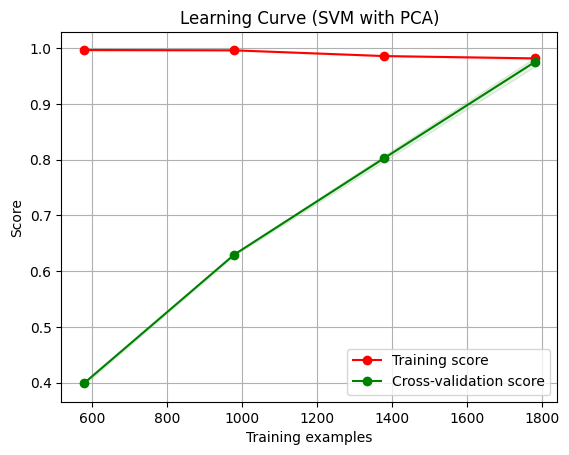

In [17]:
# Plot learning curve with PCA
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

plot_learning_curve(sv_model, "Learning Curve (SVM with PCA)", pca.transform(x), y, cv=5)
plt.show()
